# OCR 모델 이용해 text detection & text recognition 작업 수행

In [1]:
# import torch
# torch.cuda.is_available()
# torch.cuda.get_device_name(0)

In [2]:
import pandas as pd
import numpy as np
import os
import json
import pprint
import glob

import tensorflow as tf
import cv2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import paddleocr
from paddleocr import PaddleOCR, draw_ocr
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 데이터 구조 확인하기

### 데이터 목록이 제대로 있는지 확인하는 코드

# ! 다음 내용을 이용해서 각자 데이터 다운받은것 갯수 확인 부탁드려요
# 각자 코드 돌릴 때 데이터가 다를 경우 추후 오류날 가능성 있음

In [3]:
# JSON 파일 목록 정리
basic_path = 'data/HW_OCR/4.Validation/'
backgrounds = ['P.Paper/', 'T.Tablet/']
contents = ['R.Free/', 'O.Form/']
json_files_list = []
png_list = []

for background in backgrounds:
    for content in contents:
        tmp = []
        path = basic_path + background + content
        tmp = list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.json'), os.listdir(path))))
        json_files_list.append(tmp)
        print('{}.json: {}개'.format(path, len(tmp)))
        
        tmp = list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.png'), os.listdir(path))))
        png_list.append(tmp)
        print('{}.png: {}개'.format(path, len(tmp)))
        print()

data/HW_OCR/4.Validation/P.Paper/R.Free/.json: 35535개
data/HW_OCR/4.Validation/P.Paper/R.Free/.png: 35535개

data/HW_OCR/4.Validation/P.Paper/O.Form/.json: 43170개
data/HW_OCR/4.Validation/P.Paper/O.Form/.png: 43170개

data/HW_OCR/4.Validation/T.Tablet/R.Free/.json: 4789개
data/HW_OCR/4.Validation/T.Tablet/R.Free/.png: 4789개

data/HW_OCR/4.Validation/T.Tablet/O.Form/.json: 12525개
data/HW_OCR/4.Validation/T.Tablet/O.Form/.png: 12525개



In [4]:
P1 = len(json_files_list[0]) + len(json_files_list[1])
T1 = len(json_files_list[2]) + len(json_files_list[3])
print('갖고 있는 json 데이터 목록')
print(P1, T1, P1+T1)
print('데이터 사이트 - 내가 갖고 있는 데이터 목록')
print(87205 - P1, 19314 - T1, 106519 - (P1+T1))

print()

P2 = len(png_list[0]) + len(png_list[1])
T2 = len(png_list[2]) + len(png_list[3])
print('갖고 있는 png 데이터 목록')
print(P2, T2, P2+T2)
print('데이터 사이트 - 내가 갖고 있는 데이터 목록')
print(87205 - P2, 19314 - T2, 106519 - (P2+T2))

갖고 있는 json 데이터 목록
78705 17314 96019
데이터 사이트 - 내가 갖고 있는 데이터 목록
8500 2000 10500

갖고 있는 png 데이터 목록
78705 17314 96019
데이터 사이트 - 내가 갖고 있는 데이터 목록
8500 2000 10500


In [5]:
path = 'data/HW_OCR/4.Validation/P.Paper/R.Free/'
file = 'IMG_OCR_53_4PR_21045.json'
with open(path + file, 'r', encoding='UTF8') as f:
    data = json.load(f)
pprint.pprint(data)

{'Annotation': {'object_recognition': 0, 'text_language': 0},
 'Dataset': {'category': 0,
             'identifier': 'IMG_OCR_53',
             'label_path': 'HW_OCR/4.Validation/P.Paper/R.Free/',
             'name': '대용량 손글씨 데이터셋',
             'src_path': 'HW_OCR/4.Validation/P.Paper/R.Free/',
             'type': 1},
 'Images': {'acquistion_location': '자체',
            'application_field': '기타',
            'background': 0,
            'data_captured': '2021.09.06',
            'height': 3482,
            'identifier': 'IMG_OCR_53_4PR_21045',
            'media_type': 0,
            'pen_color': 'red',
            'pen_type': 0,
            'type': 'png',
            'width': 2469,
            'writer_age': 47,
            'writer_sex': 1,
            'written_content': 1},
 'bbox': [{'data': '021045',
           'id': 1,
           'x': [1857, 1857, 2262, 2262],
           'y': [153, 248, 153, 248]},
          {'data': '경상북도',
           'id': 2,
           'x': [347, 347, 746, 74

### 결과 데이터 구성 요소

- label에서 가져올 정보
    - id
        - Images > identifier
    - image
        - Images > identifer + '.' + type
        - 두 요소를 .으로 이어 붙어야 한다.
    - age
        - Images > writer_age
    - sex
        - Images > writer_sex
    - background
        - Images > background
        - 종이: 0
        - 타블렛: 1
    - text_origin
        - bbox > data
    - bbox_origin
        - bbox > data, id, x, y 순서로 정렬
        - x와 y에 존재하는 숫자는 좌측 하부, 좌측 상부, 우측 하부, 우측 상부 순서로 정렬되어 있음
        - OCR 결과물과 동일한 순서로 작업을 할 계획이라
            - 좌측 하부, 우측 하부,우측 상부, 좌측 상부 순으로 [x, y] 묶음의 나열로 바꿀것

<br>

- OCR 모델에서 가져올 정보
    - text_90
        - 판별 score가 90점이 넘는 글씨의 텍스트 값
    - bbox_90
        - 판별 score가 90점이 넘는 글씨의 bbox 값
        - bbox값이 좌측 하부, 우측 하부,우측 상부, 좌측 상부 순으로 [x, y] 묶음의 나열로 있음
    - text_80
        - 판별 score가 80점이 넘는 글씨의 텍스트 값
    - bbox_80
        - 판별 score가 80점이 넘는 글씨의 bbox 값

In [6]:
# 결과 데이터 컬럼 및 df 생성

col = ['id', 'image', 'age', 'sex', 'background', 'text_origin', 'bbox_origin', 'text_90', 'bbox_90', 'text_80', 'bbox_80']

ocr_df = pd.DataFrame(columns = col)
ocr_df

,id,image,age,sex,background,text_origin,bbox_origin,text_90,bbox_90,text_80,bbox_80


In [7]:
# JSON 파일 로드 함수
def load_json(json_path):
    try:
        encoder = 'utf-8'
        with open(json_path, 'r', encoding = encoder) as f:
            data = json.load(f)
    except:
        try:
            encoder = 'cp949'
            with open(json_path, 'r', encoding = encoder) as f:
                data = json.load(f)
            
        except:
            encoder = 'euc-kr'
            with open(json_path, 'r', encoding = encoder) as f:
                data = json.load(f)
    
    return data

# JSON 파일 목록 정리
basic_path = 'data/HW_OCR/4.Validation/'
backgrounds = ['P.Paper/', 'T.Tablet/']
content = 'R.Free/'
json_files_list = []

for background in backgrounds:
    tmp = []
    path = basic_path + background + content
    tmp = list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.json'), os.listdir(path))))
    json_files_list += tmp
    
print(len(json_files_list))


40324


In [8]:
def json2ocrdf(json_files_list):
    
    for i, json_file in enumerate(json_files_list):
        if i % 100 == 0:
            print(i, end = ' ')
        # JSON 파일 경로
        json_path = json_file
        data = load_json(json_path)

        image_path = 'data/' + data['Dataset']['src_path'] + data['Images']['identifier'] + '.' + data['Images']['type']
#         print(image_path)

        # 각 단어의 바운딩 박스와 텍스트 정보
        texts_list = []
        bounding_box_list = []

        # 전처리된 이미지 리스트
        for word in data['bbox']:
            text = word['data']
            texts_list.append(text)
#             print(text)

            # 좌표들 순서 위치            # paddle_ocr bbox 결과 좌표 순서 위치
            # 1    3                    # 3    2
            # 0    2                    # 0    1
            bounding_box = [[word['x'][0], word['y'][0]],
                            [word['x'][2], word['y'][2]],
                            [word['x'][3], word['y'][3]],
                            [word['x'][1], word['y'][1]]
                           ]
            bounding_box_list.append(bounding_box)
#             print(bounding_box)

        ocr_id = data['Images']['identifier']
        ocr_image = image_path
        ocr_age = data['Images']['writer_age']
        ocr_sex = data['Images']['writer_sex']
        ocr_background = data['Images']['background']
        ocr_text_origin = texts_list
        ocr_bbox_origin = bounding_box_list
        ocr_text_90 = None
        ocr_bbox_90 = None
        ocr_text_80 = None
        ocr_bbox_80 = None

        ocr_df.loc[len(ocr_df)] = [ocr_id, ocr_image, ocr_age, ocr_sex, ocr_background, ocr_text_origin, ocr_bbox_origin,
                                   None, None, None, None]


In [9]:
json2ocrdf(json_files_list[0:1000])

0 100 200 300 400 500 600 700 800 900 

In [10]:
ocr_df.tail()

,id,image,age,sex,background,text_origin,bbox_origin,text_90,bbox_90,text_80,bbox_80
995,IMG_OCR_53_4PR_05458,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,45,0,0,"[005458, 서울특별시, 세종특별자치시, 경상북도, 울산광역시, 경산시, 창원시...","[[[1850, 147], [2104, 147], [2104, 226], [1850...",None,None,None,None
996,IMG_OCR_53_4PR_05459,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,45,0,0,"[005459, 전라북도, 광주광역시, 충청북도, 경기도, 여수시, 사하구, 강서구...","[[[1856, 132], [2251, 132], [2251, 224], [1856...",None,None,None,None
997,IMG_OCR_53_4PR_05460,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,45,0,0,"[005460, 제주특별자치도, 충청북도, 경상북도, 세종특별자치시, 의성군, 관악...","[[[1874, 141], [2106, 141], [2106, 229], [1874...",None,None,None,None
998,IMG_OCR_53_4PR_05461,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,45,0,0,"[부산광역시, 대전광역시, 울산광역시, 전라북도, 안산시, 계룡시, 안양시, 창원시...","[[[382, 1012], [679, 1012], [679, 1134], [382,...",None,None,None,None
999,IMG_OCR_53_4PR_05462,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,45,0,0,"[005462, 대구광역시, 세종특별자치시, 전라남도, 강원도, 통영시, 영도구, ...","[[[1863, 132], [2222, 132], [2222, 231], [1863...",None,None,None,None


In [11]:
ocr_df.to_csv('result_df_sample.csv', index = False)

In [14]:
ocr_df['bbox_origin'][0][0]

[[1941, 138], [2190, 138], [2190, 223], [1941, 223]]

In [ ]:
json2ocrdf(json_files_list[1000:10000])

In [ ]:
ocr_df.tail()

In [ ]:
json2ocrdf(json_files_list[10000:20000])

In [ ]:
ocr_df.tail()

In [ ]:
json2ocrdf(json_files_list[20000:30000])

In [ ]:
ocr_df.tail()

In [ ]:
json2ocrdf(json_files_list[30000:])

In [ ]:
ocr_df.tail()

In [ ]:
ocr_df.to_csv('result_df.csv', index = False)

# OCR_paddle

## OCR 모델 적용하여 

In [15]:
ocr_model = PaddleOCR(lang = 'korean')

img_path = '2ali6i.jpg'
result = ocr_model.ocr(img_path, cls = False)

[2024/08/27 21:51:06] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model

In [16]:
res = result[0]
print(type(res))
boxes = [res[i][0] for i in range(len(result[0]))] # 
texts = [res[i][1][0] for i in range(len(result[0]))]
scores = [float(res[i][1][1]) for i in range(len(result[0]))]

ocr_text_90 = []
ocr_bbox_90 = []
ocr_text_80 = []
ocr_bbox_80 = []

# bbox가 직각사각형이 아닐 수도 있다.
# 관련된 부분 전처리 필요

for t, s, b in zip(texts, scores, boxes):
    print(t, s, b)
    if s >= 0.8:
        ocr_text_80.append(t)
        ocr_bbox_80.append(b)
        
        if s >= 0.9:
            ocr_text_90.append(t)
            ocr_bbox_90.append(b)

print()
print(ocr_text_90, ocr_bbox_90)
print()
print(ocr_text_80, ocr_bbox_90)

<class 'list'>
Riseppointed 0.8323544859886169 [[130.0, 152.0], [550.0, 77.0], [569.0, 181.0], [149.0, 255.0]]
BUT 0.8771654963493347 [[69.0, 214.0], [364.0, 214.0], [364.0, 334.0], [69.0, 334.0]]
N요T 0.7563906311988831 [[429.0, 209.0], [729.0, 220.0], [724.0, 342.0], [425.0, 332.0]]
SURPRISE 0.9809025526046753 [[331.0, 356.0], [620.0, 308.0], [632.0, 377.0], [343.0, 425.0]]

['SURPRISE'] [[[331.0, 356.0], [620.0, 308.0], [632.0, 377.0], [343.0, 425.0]]]

['Riseppointed', 'BUT', 'SURPRISE'] [[[331.0, 356.0], [620.0, 308.0], [632.0, 377.0], [343.0, 425.0]]]


In [17]:
for t, s, b in zip(texts, scores, boxes):
    print(b)

[[130.0, 152.0], [550.0, 77.0], [569.0, 181.0], [149.0, 255.0]]
[[69.0, 214.0], [364.0, 214.0], [364.0, 334.0], [69.0, 334.0]]
[[429.0, 209.0], [729.0, 220.0], [724.0, 342.0], [425.0, 332.0]]
[[331.0, 356.0], [620.0, 308.0], [632.0, 377.0], [343.0, 425.0]]


In [18]:
ocr_bbox_80[0]

[[130.0, 152.0], [550.0, 77.0], [569.0, 181.0], [149.0, 255.0]]

### 전처리 작업
- 손글씨만 활용해야 함
- 문서내에 인쇄된 글씨 부분은 제외해야 함
- 반복적으로 나오는 부분을 데이터 확인해 미리 만들어 둠
- 목록에서 제거하기로 함

In [ ]:
# 자간 데이터 코드 :

# def is_handwritten(text, max_char_spacing=5):
#     char_positions = [ord(c) for c in text]
#     spacings = [char_positions[i+1] - char_positions[i] for i in range(len(char_positions) - 1)]
#     average_spacing = sum(spacings) / len(spacings) if spacings else 0
#     return average_spacing > max_char_spacing

# # OCR 결과에서 손글씨만 필터링

# handwritten_texts = [text for text in ocr_results if is_handwritten(text)]

In [ ]:
# # predict > texts
# # json > texts_list

# print('< 예측 | 실제 > ')
# for predict, real in zip(texts, texts_list):
#     print('{} | {}'.format(predict, real))

[[130.0, 152.0], [550.0, 77.0], [569.0, 181.0], [149.0, 255.0]]
Riseppointed
0.8323544859886169


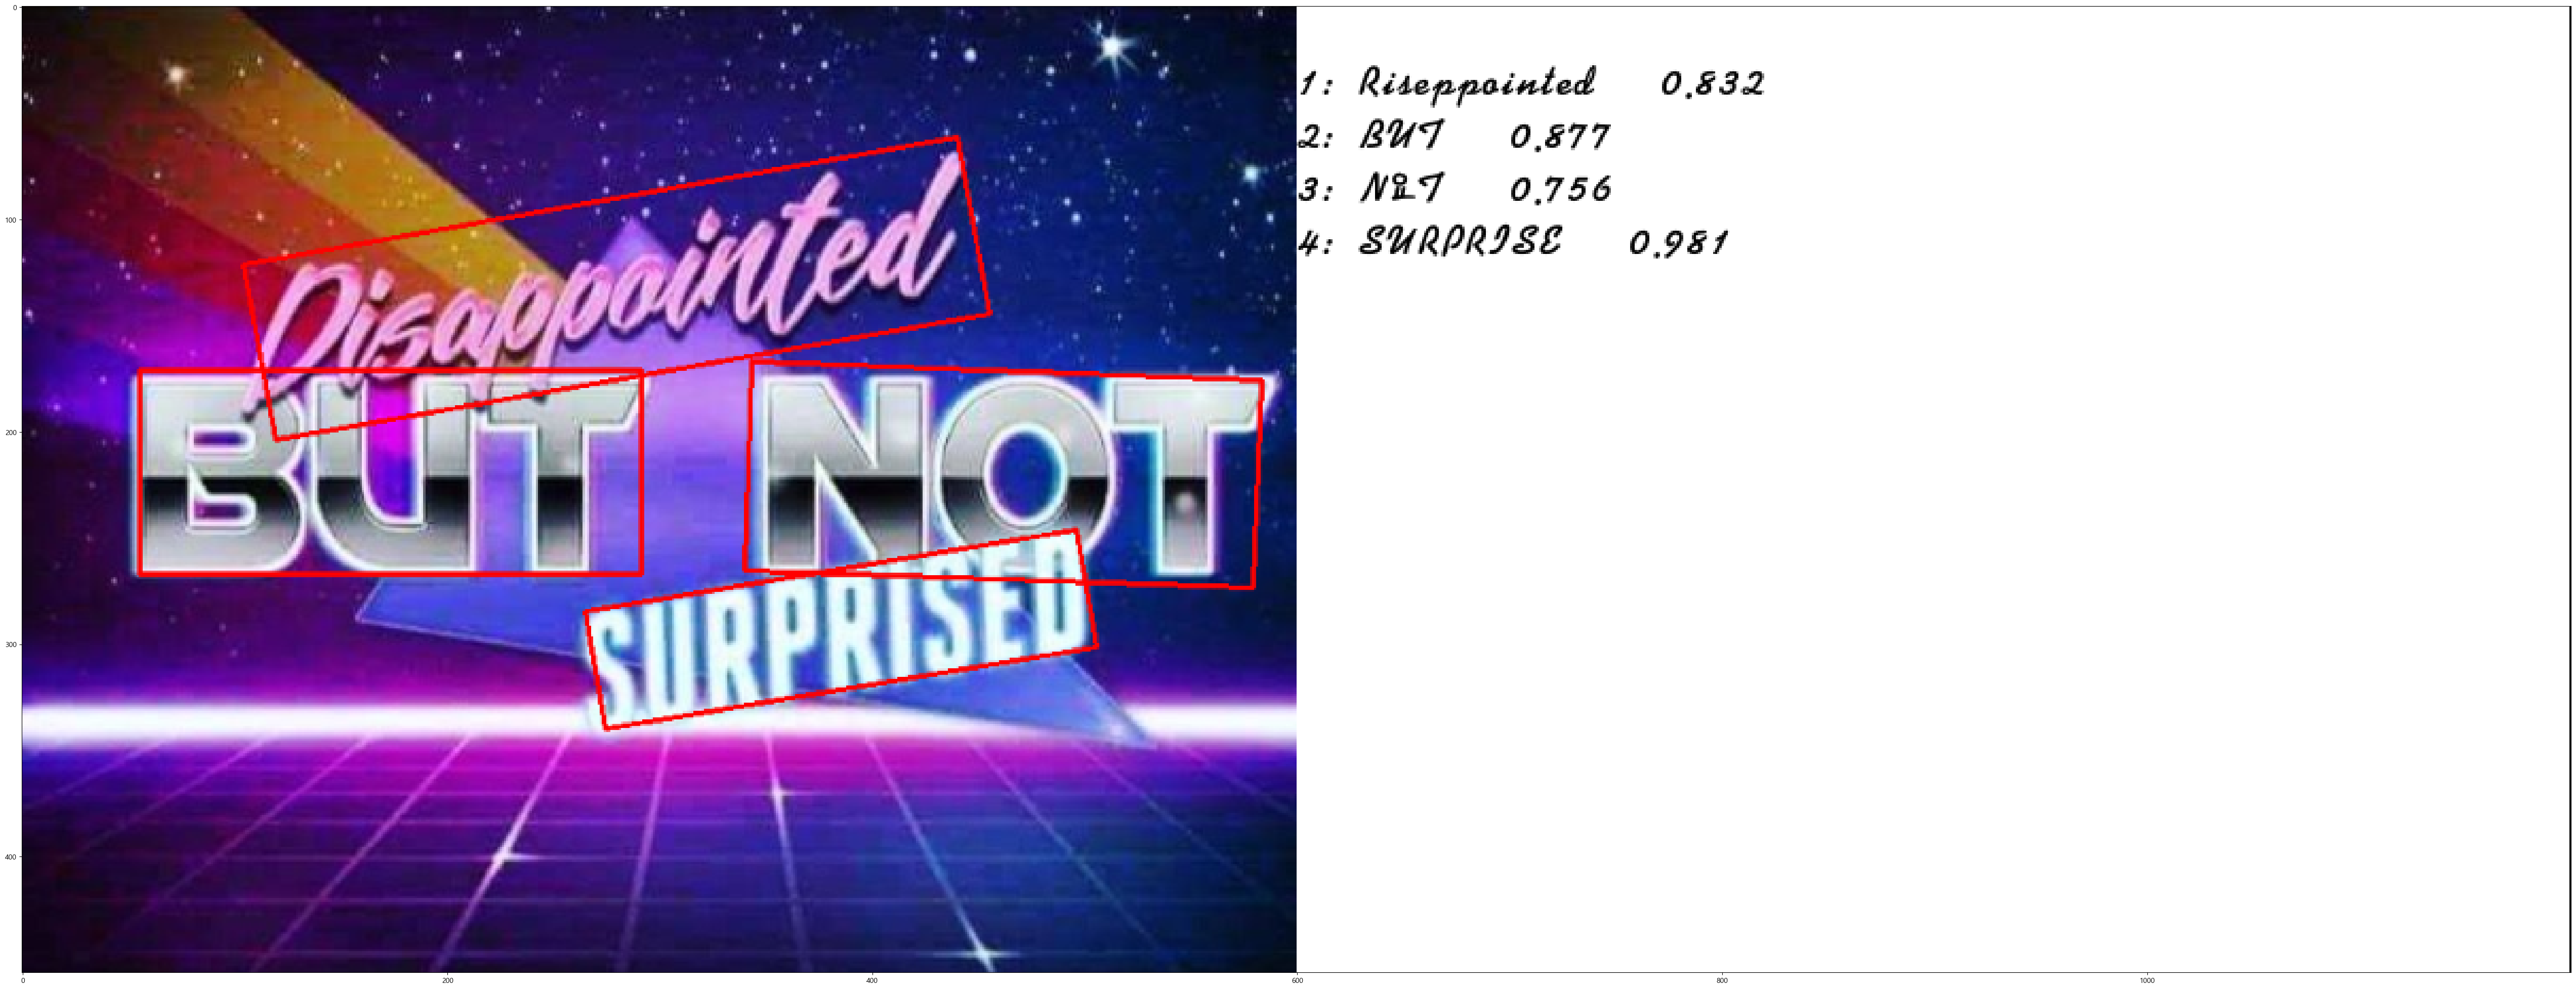

In [19]:
#for res in result:
print(boxes[0])
print(texts[0])
print(scores[0])#, Text: {res[1]}

# Specifying font path for draw_ocr method
font_path = 'C:/Users/UserK/ds_study/DL_proj/PaddleOCR-main/doc/fonts/korean.TTF'

img_path = 'C:/Users/UserK/ds_study/DL_proj/2ali6i.jpg'

# imports image
img = cv2.imread(img_path) 

# reorders the color channelsa
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# Visualize our image and detections
# resizing display area
plt.figure(figsize = (65, 65))

# draw annotations on image
annotated = draw_ocr(img, boxes, texts, scores, font_path = font_path) 

# show the image using matplotlib
plt.imshow(annotated)